In [1]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import networkx as nx
import ast
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from functions import get_energy_cost
from functions import energy_model
from functions import poly_features_model
from functions import slope_computing
from functions import build_node_graph
from functions import compute_route

# Ingestion

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562 entries, 561 to 0
Columns: 683 entries, 0 to 682
dtypes: float64(683)
memory usage: 2.9 MB


None

max:  1780.29
min:  673.22
mean:  1200.5576816744215
median:  1240.315


Text(0.9, -0.2, 'All measurements in meters [m]')

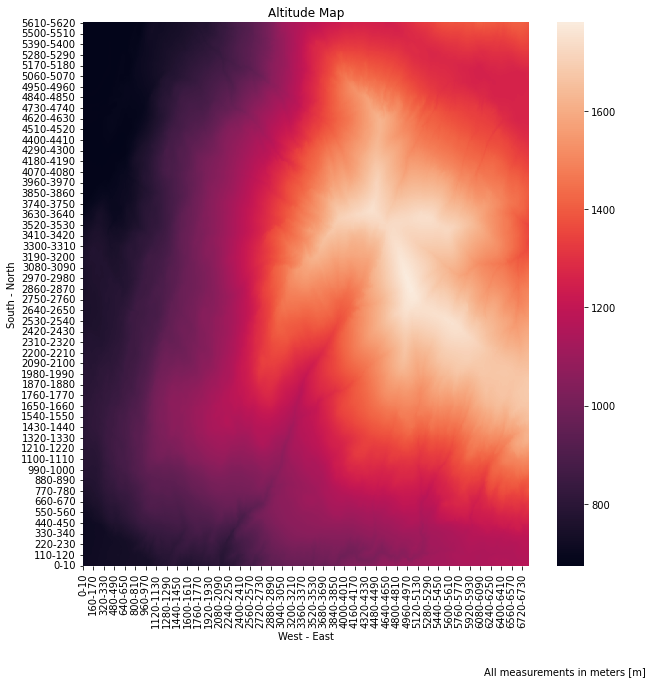

In [8]:
df_alt_map = pd.read_csv('data/altitude_map (1).csv',header=None) # reading map info (altitude in [m])
df_alt_map.index = df_alt_map.index[::-1] # South-Western corner of the map (x=0, y=0)
display(df_alt_map.info())
# Checking for outliers and skewness
print("max: ",df_alt_map.max().max())
print("min: ",df_alt_map.min().min())
print("mean: ",df_alt_map.mean().mean())
print("median: ",df_alt_map.median().median())
# No evident outliers seen
# Height seems to have a normal distribution
# Data type is consistent
assert df_alt_map.isnull().sum().sum() == 0 # Check on empty values
# No missing values
df_alt_map.index = [f"{elem*10}-{elem*10+10}" for elem in df_alt_map.index] # set y_orig axis resolution (10m)
df_alt_map.columns = [f"{elem*10}-{elem*10+10}" for elem in df_alt_map.columns] # set x axis resolution (10m)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_alt_map)
ax.set(xlabel='West - East', ylabel='South - North',title='Altitude Map')
ax.text(0.9, -0.2, 'All measurements in meters [m]', transform=ax.transAxes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gradient     65 non-null     float64
 1   energy_cost  65 non-null     float64
dtypes: float64(2)
memory usage: 1.1 KB


None

'max: '

gradient        0.458577
energy_cost    17.383337
dtype: float64

'min: '

gradient      -0.459229
energy_cost    0.455766
dtype: float64

'mean: '

gradient      -0.000129
energy_cost    6.307908
dtype: float64

'median: '

gradient      -0.002166
energy_cost    3.497927
dtype: float64

Text(0, 0.5, 'energy_cost [ J / (Kg*min)]')

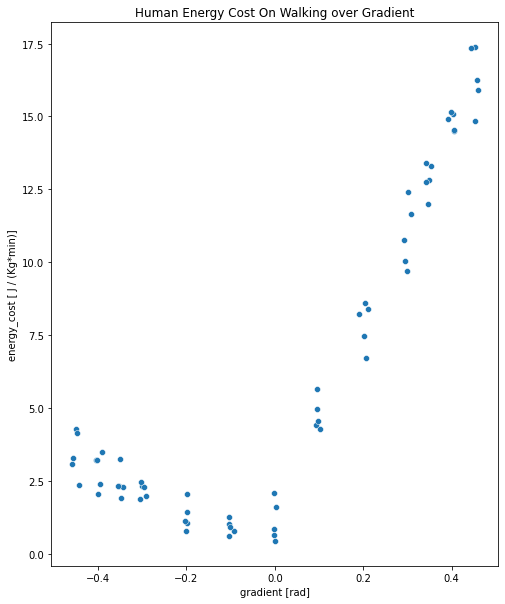

In [3]:
df_ener_cost = pd.read_csv('data/energy_cost.csv') # reading energy cost on slope walking
display(df_ener_cost.info())
# Checking for outliers and skewness
display("max: ",df_ener_cost.max())
display("min: ",df_ener_cost.min())
display("mean: ",df_ener_cost.mean())
display("median: ",df_ener_cost.median())
fig, ax = plt.subplots(figsize=(8, 10))
sns.scatterplot(data=df_ener_cost, x="gradient", y="energy_cost")
ax.set(title='Human Energy Cost On Walking over Gradient')
plt.xlabel('gradient [rad]')
plt.ylabel('energy_cost [ J / (Kg*min)]')

# Modelling

## Polynomial regression

Multiple degrees of polynomial were evaluated using MSE.

A degree of 4 was finally chosen since it reduced substantially the fitting error while not overfitting on sample data

In [4]:
x_orig = df_ener_cost.loc[:,'gradient'].values.reshape(-1, 1)
y_orig = df_ener_cost.loc[:,'energy_cost'].values.reshape(-1, 1)

# Evaluating best (non overfitting value)
for degree in range(9):
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=degree)
    x_poly = poly_features.fit_transform(x_orig)
    # Train
    model = LinearRegression()
    model.fit(x_poly, y_orig)
    # EVALUATE MSE
    y_pred = model.predict(x_poly)
    mse = mean_squared_error(y_orig, y_pred)
    print(f"Mean Squared Error for degree {degree}: {mse}")

# Create polynomial features
degree = 4
poly_features = PolynomialFeatures(degree=degree)
x_poly = poly_features.fit_transform(x_orig)
# Train
model = LinearRegression()
model.fit(x_poly, y_orig)
# EVALUATE MSE
y_pred = model.predict(x_poly)
mse = mean_squared_error(y_orig, y_pred)
# SAVING THE MODEL
joblib.dump(model, 'models/energy_model.pkl')
joblib.dump(poly_features, 'models/poly_features_model.pkl')

Mean Squared Error for degree 0: 29.20858348239694
Mean Squared Error for degree 1: 7.984462630525669
Mean Squared Error for degree 2: 0.7545854881751669
Mean Squared Error for degree 3: 0.717681978252707
Mean Squared Error for degree 4: 0.48118299960013944
Mean Squared Error for degree 5: 0.47697906605976725
Mean Squared Error for degree 6: 0.459020102962174
Mean Squared Error for degree 7: 0.4309812855099043
Mean Squared Error for degree 8: 0.39604379542434687


['models/poly_features_model.pkl']

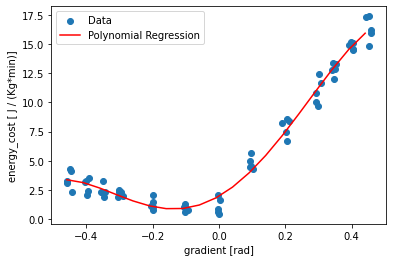

In [5]:
# VISUALIZING THE MODEL FIT
# Predict on new data
min_indep = df_ener_cost.loc[:,'gradient'].min()
max_indep = df_ener_cost.loc[:,'gradient'].max()
X_new = np.arange(min_indep, max_indep, 0.05).reshape(-1, 1)
X_new_poly = poly_features.transform(X_new)
y_pred = model.predict(X_new_poly)
# Visualize the results
plt.scatter(x_orig, y_orig, label='Data')
plt.plot(X_new, y_pred, color='red', label='Polynomial Regression')
plt.xlabel('gradient [rad]')
plt.ylabel('energy_cost [ J / (Kg*min)]')
plt.legend()
plt.show()

# Optimisation
Node approximation approach implemented

## Test route optimization

In [22]:
df_alt_map = pd.read_csv('data/altitude_map test.csv',header=None) # reading map info (altitude in [m])
display("test mini map: ",df_alt_map)
node_graph=nx.Graph()
build_node_graph(df_alt_map,node_graph)
print("Route from (4,2) to (0,0):")
nx.shortest_path(node_graph, '(4,2)', '(0,0)', weight='weight')

'test mini map: '

,0,1,2,3,4,5
0,0,6,0,1,2,3
1,0,6,5,4,0,0
2,0,6,6,3,2,0
3,0,0,1,1,1,0
4,0,1,0,1,0,1


Route from (4,2) to (0,0):


['(4,2)', '(3,2)', '(3,1)', '(3,0)', '(2,0)', '(1,0)', '(0,0)']

## Real Map Route Planning

In [21]:
df_alt_map = pd.read_csv('data/altitude_map (1).csv',header=None) # reading map info (altitude in [m])
df_alt_map.index = df_alt_map.index[::-1] # South-Western corner of the map (x=0, y=0)
df_alt_map

,0,1,2,3,4,5,6,7,8,9,...,673,674,675,676,677,678,679,680,681,682
561,675.36,675.33,675.32,675.30,675.44,677.61,679.24,679.71,678.61,675.86,...,1404.99,1404.17,1403.03,1401.80,1400.64,1398.73,1397.44,1395.96,1393.98,1391.49
560,675.36,675.33,675.32,675.30,675.44,677.61,679.24,679.71,678.61,675.86,...,1404.99,1404.17,1403.03,1401.80,1400.64,1398.73,1397.44,1395.96,1393.98,1391.49
559,675.37,675.35,675.36,675.37,676.26,678.53,679.31,679.71,677.55,675.83,...,1402.85,1401.96,1400.68,1399.39,1398.30,1396.33,1394.58,1393.27,1391.28,1388.85
558,675.45,675.44,675.42,675.49,677.27,679.29,679.56,679.21,676.39,676.46,...,1400.30,1399.34,1398.11,1396.75,1395.60,1394.35,1391.63,1390.11,1388.52,1386.42
557,675.44,675.44,675.52,676.00,678.38,679.47,679.91,678.38,675.98,676.58,...,1397.66,1396.36,1395.20,1394.15,1392.84,1391.69,1390.37,1387.24,1385.18,1383.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,713.67,714.05,714.26,714.61,714.92,715.21,715.62,715.95,716.26,716.66,...,1164.47,1165.24,1165.30,1165.59,1165.88,1166.38,1166.77,1167.32,1168.14,1167.94
3,713.71,713.93,714.21,714.55,714.86,715.13,715.59,715.91,716.27,716.61,...,1167.99,1168.27,1168.78,1169.27,1169.40,1169.36,1169.24,1169.78,1169.77,1169.81
2,713.68,713.95,714.16,714.53,714.92,715.23,715.72,715.92,716.19,716.61,...,1172.41,1172.42,1172.05,1171.87,1171.33,1171.28,1171.39,1171.11,1170.99,1170.60
1,713.54,713.88,714.14,714.49,714.83,715.27,715.56,715.84,716.18,716.54,...,1174.13,1174.29,1174.21,1173.53,1173.29,1172.70,1172.08,1171.49,1171.08,1170.68


In [3]:
# READ OR BUILD NODE GRAPH IF NOT FOUND
try:
    node_graph = pickle.load(open('models/node_graph.pickle', 'rb'))
except:
    node_graph=nx.Graph()
    build_node_graph(df_alt_map,node_graph)
    pickle.dump(node_graph, open('models/node_graph.pickle', 'wb'))

# Simple Reporting

Please select trails starting position

Notes:

	- Trail starts anywhere on mountains south-most position
	- Fixed destination: Lodge located on (200,559)

Enter an value between: 0 and 682 and then hit Enter

Route will start on x = 200, y = 0
Route will end on x = 200, y = 559)


'route'

,y_coord,x_coord
0,0,200
1,1,200
2,2,200
3,2,199
4,2,198
...,...,...
835,559,196
836,559,197
837,559,198
838,559,199


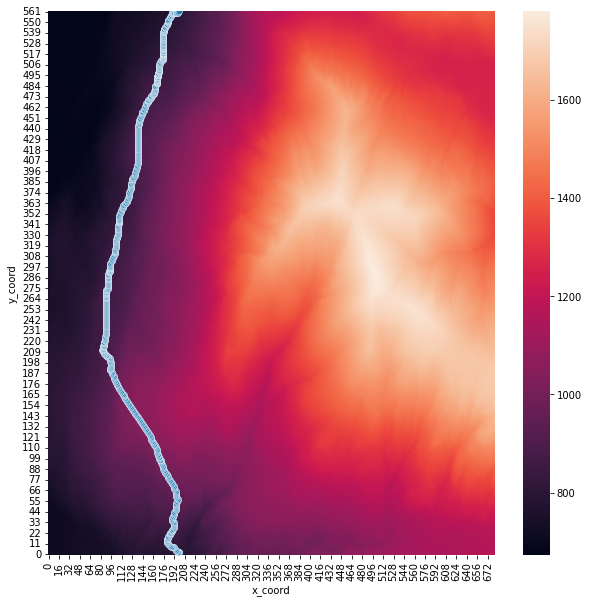

<Figure size 432x288 with 0 Axes>

In [20]:
# USER INPUT START POSITION

max_pos_idx = df_alt_map.index[-1]
min_pos_col = df_alt_map.columns[0]
max_pos_col = df_alt_map.columns[-1]
horiz_select = -1
print("Please select trails starting position\n\nNotes:\n")
print("\t- Trail starts anywhere on mountains south-most position")
print("\t- Fixed destination: Lodge located on (200,559)\n")
print(f"Enter an value between: {min_pos_col} and {max_pos_col} and then hit Enter\n")
while horiz_select not in  df_alt_map.columns:
    horiz_select = input(f"Enter an value between: {min_pos_col} and {max_pos_col} and then hit Enter")
    horiz_select = int(horiz_select)

starting_point = (horiz_select,max_pos_idx)
print(f"Route will start on x = {starting_point[0]}, y = {starting_point[1]}")
print(f"Route will end on x = 200, y = 559)")
route_df = compute_route(node_graph,starting_point)
display("route",route_df)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_alt_map, ax=ax)
route_df.y_coord = route_df.y_coord[::-1].values # fix scatterplot axis
sns.scatterplot(data=route_df, x="x_coord", y="y_coord", ax=ax)
plt.show()

# SAVE RESULTS
route_df.to_csv(f'planned_routes/route_x_{starting_point[0]}_y_{starting_point[1]}.csv', index = False, encoding='utf-8')
plt.savefig(f'planned_routes/route_x_{starting_point[0]}_y_{starting_point[1]}.png')